Below you will find my results and recommendations for the Punt Analytics Competition.


I was able to articulate more details, provide more visuals, and discuss pros and cons in my powerpoint presentation attached.


The aim of this study is to analyze league punting data from 2016 and 2017, and recommend rules that will reduce concussions on punting plays while maintaining the integrity of the game.


In [1]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import numpy as np

game_data = pd.read_csv('game_data.csv')
play_info = pd.read_csv('play_information.csv')
play_player_role = pd.read_csv('play_player_role_data.csv')
player_punt = pd.read_csv('player_punt_data.csv')
injuries = pd.read_csv('video_review.csv')
pre_2016 = pd.read_csv('NGS-2016-pre.csv')
reg_2016_1 = pd.read_csv('NGS-2016-reg-wk1-6.csv')
reg_2016_2 = pd.read_csv('NGS-2016-reg-wk7-12.csv')
reg_2016_3 = pd.read_csv('NGS-2016-reg-wk13-17.csv')
post_2016 = pd.read_csv('NGS-2016-post.csv')
pre_2017 = pd.read_csv('NGS-2017-pre.csv')
reg_2017_1 = pd.read_csv('NGS-2017-reg-wk1-6.csv')
reg_2017_2 = pd.read_csv('NGS-2017-reg-wk7-12.csv')
reg_2017_3 = pd.read_csv('NGS-2017-reg-wk13-17.csv')
post_2017 = pd.read_csv('NGS-2017-post.csv')

C:\Users\Yofftop\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Step 1 - Assess the problem

Here I am checking to see what the magnitude of the problem is, and creating a direction for the analysis

In [2]:
punt_count = len(play_info)
con_count = len(injuries)

print("Number of punt plays: ")
print(punt_count) 
print("Number of concussion plays: ")
print(con_count)

Number of punt plays: 
6681
Number of concussion plays: 
37


It is interesting to note that while concussions are definitely a problem, the actual number is very small (37). Making the problem even more difficult to solve. 

Within punting plays, let's investigate which are the most dangerous. To do so, we will crawl through the play description and categorize each play as a fair catch, out of bounds, touchback, return, muff, or downed.

In [3]:
#Outcomes of punts
#1- Fair Catch
#2- Out of bounds
#3- Touchback
#4- Return
#5- Muff
#6- Downed

unique_con_id = []

for row in range(len(injuries)):
    game_id = str(injuries.iloc[row,1])
    play_id = str(injuries.iloc[row,2])
    unique_con_id.append(game_id+play_id)

fc = 0
ob = 0
tb = 0
rt = 0
mf = 0
dn = 0
fc_c = 0
ob_c = 0
tb_c = 0
rt_c = 0
mf_c = 0
dn_c = 0

ids = []
rt_ids = []
rt_con_ids = []


for i in range(len(play_info)):
    game_id_1 = str(play_info.iloc[i,2])
    play_id_1 = str(play_info.iloc[i,5])
    uni_id = game_id_1+play_id_1
    
    ids.append(uni_id)
    
    if "fair catch" in play_info.iloc[i,13]:
        fc += 1
    if "out of bounds" in play_info.iloc[i,13]:
        ob += 1
    if "Touchback" in play_info.iloc[i,13]:
        tb += 1
    if "for" in play_info.iloc[i,13]:
        rt += 1
        rt_ids.append(uni_id)
    if "MUFFS" in play_info.iloc[i,13]:
        mf += 1
    if "downed" in play_info.iloc[i,13]:
        dn += 1
    if uni_id in unique_con_id:
        if "fair catch" in play_info.iloc[i,13]:
            fc_c += 1
        if "out of bounds" in play_info.iloc[i,13]:
            ob_c += 1
        if "Touchback" in play_info.iloc[i,13]:
            tb_c += 1
        if "for" in play_info.iloc[i,13]:
            rt_c += 1
            rt_con_ids.append(uni_id)
        if "MUFFS" in play_info.iloc[i,13]:
            mf_c += 1
        if "downed" in play_info.iloc[i,13]:
            dn_c += 1

outcomes = ['Fair Catch', 'OB', 'Touchback', 'Return', 'Muff', 'Downed']
total_plays = [fc,ob,tb,rt,mf,dn]
conc_plays = [fc_c,ob_c,tb_c,rt_c,mf_c,dn_c]

dc = {'Outcomes': outcomes, 'Concussion Plays': conc_plays, 'Total Plays': total_plays, 
      'Percent of Inj': np.array(conc_plays)*100/np.array(total_plays)}
df = (pd.DataFrame(dc))

print(df)

     Outcomes  Concussion Plays  Total Plays  Percent of Inj
0  Fair Catch                 2         1659        0.120555
1          OB                 0          669        0.000000
2   Touchback                 0          407        0.000000
3      Return                36         4488        0.802139
4        Muff                 2          203        0.985222
5      Downed                 3          811        0.369914


Punt plays that result in returns appear to be more dangerous than the rest

Next I want to investiage who is most likely to suffer a concussion on a punting play

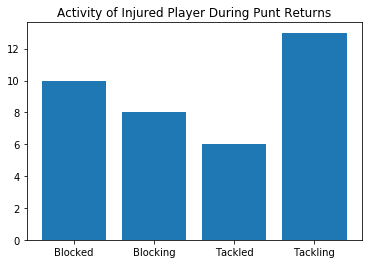

In [4]:
freq = injuries.groupby('Player_Activity_Derived').count()
plt.bar(freq.index.values,freq.iloc[:,0])
plt.title("Activity of Injured Player During Punt Returns")
plt.show()

There is a fairly even distribution among the players who get injured. I was surprised to see that the returner isn't at much at risk as the blockers and tacklers.

There does appear to be a high proportion of players injured who are on the punting team (blocked and tackling). It's evident that something needs to change to prevent those players from sustaining injuries.

Next I hope to investigate if there are any other factors in the dataset that are correlated with concussions. To do so, I am creating a giant correlation matrix of each play using the data in the various spreadsheets. The factors I am including are:

1) Number of box defenders

2) Number of outside blockers

3) Number of returners 

4) Return yards

5) Punt distance

6) Punt hangtime

7) Result of play (fair catch, return, out of bounds, etc.)

8) Distance from center of field ball is snapped from

9) Line of scrimmage (defined as distance from end zone)

10) Whether there was any injury on the play or not

11) Whether there was any penalty on the play or not

The categorical response variable is was there a concussion on the play - yes(1) or no(0)

---

Many factors that are not involved in the actual play were not included, such as weather, score, indoor/outdoor, home team, away team, year, regular season/post season/pre season, etc. I chose not to include these because there is nothing actionable that can come out of including these variables in the analysis. None of them can be changed with a rule change. While I'm sure something like weather affects if there is a return or not, nothing can be done about this.


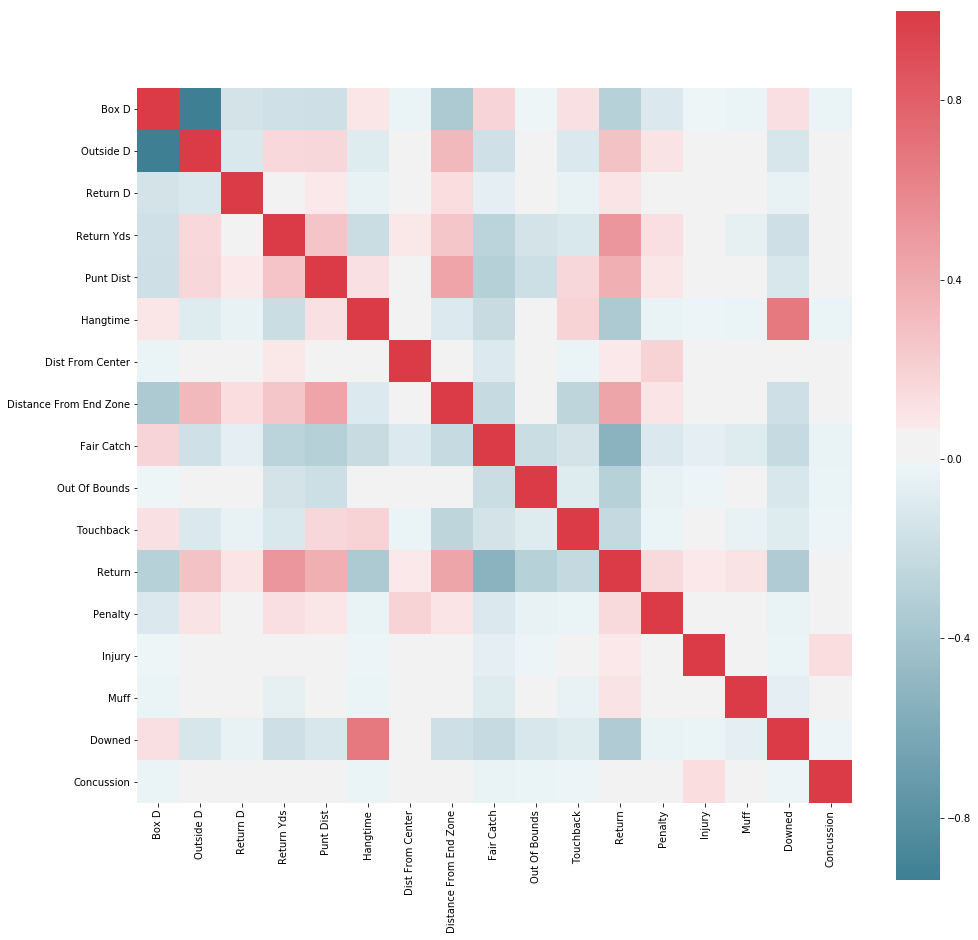

In [5]:
#Create unique IDs of all punt plays
ids = []

for i in range(len(play_info)):
    game_id_1 = str(play_info.iloc[i,2])
    play_id_1 = str(play_info.iloc[i,5])
    uni_id = game_id_1+play_id_1    
    ids.append(uni_id)

#Part 1 - Get Formations

formation = {}
for i in ids:
    formation[i] = []

for j in range(len(play_player_role)):
    game_id = str(play_player_role.iloc[j,1])
    play_id = str(play_player_role.iloc[j,2])
    uni_id = game_id+play_id
    
    if uni_id in ids:
        formation[uni_id].append(play_player_role.iloc[j,4])

def formation_matrix(dictionary_of_formations):
    
    fomration_mat = {}
    
    for i in dictionary_of_formations:
        
        fomration_mat[i] = []
        
        box = 0
        OBs = 0
        RTs = 0
        
        for j in dictionary_of_formations[i]:
            #Linemen
            if j == 'PDL2':
                box += 1
            elif j == 'PDR2':
                box += 1
            elif j == 'PDR1':
                box += 1
            elif j == 'PDL1':
                box += 1
            elif j == 'PDR4':
                box += 1
            elif j == 'PDL4':
                box += 1        
            elif j == 'PDR5':
                box += 1
            elif j == 'PDL5':
                box += 1
            elif j == 'PDL3':
                box += 1
            elif j == 'PDR3':
                box += 1
            
            
            #Linebackers
            elif j == 'PLM':
                box += 1
            elif j == 'PLR':
                box += 1
            elif j == 'PLL':
                box += 1
            elif j == 'PLL1':
                box += 1
            elif j == 'PLR1':
                box += 1
            elif j == 'PLL2':
                box += 1
            elif j == 'PLR2':
                box += 1
            elif j == 'PLL3':
                box += 1
            elif j == 'PLR3':
                box += 1

            #Outsiders
            elif j == 'VL':
                OBs += 1
            elif j == 'VRi':
                OBs += 1
            elif j == 'VRo':
                OBs += 1
            elif j == 'VR':
                OBs += 1
            elif j == 'VLi':
                OBs += 1
            elif j == 'VLo':
                OBs += 1

                
            #Returnmen
            elif j == 'PR':
                RTs += 1
            elif j == 'PFB':
                RTs += 1
            elif j == 'PFB1':
                RTs += 1
            elif j == 'PFB2':
                RTs += 1
        
        fomration_mat[i].append(box)
        fomration_mat[i].append(OBs)
        fomration_mat[i].append(RTs)
    
    return fomration_mat

THEmatrix = formation_matrix(formation)

#Part 2 - Get Return Yards

for i in range(len(play_info)):
    game_id = str(play_info.iloc[i,2])
    play_id = str(play_info.iloc[i,5])
    pid = game_id+play_id
    play = (str(play_info.iloc[i,-1]))
    if " for " in play:
        result = play.split(" for ",1)[1]
        yards = result[0:2]
        if yards == 'no':
            yards_ = 0
        if yards == 'on':
            yards = yards_  
        if yards == 'L.':
            yards = yards_  
        if yards != 'no':
            yards_ = int(yards)
    else:
        yards_ = 0
    if pid in THEmatrix:
        THEmatrix[pid].append(yards_)

#Part 3 - Get Punt Dist

for i in range(len(play_info)):
    game_id = str(play_info.iloc[i,2])
    play_id = str(play_info.iloc[i,5])
    pid = game_id+play_id
    play = (str(play_info.iloc[i,-1]))
    if " punts " in play:
        result = play.split(" punts ",1)[1]
        yards = result[0:2]
        if yards != 'no':
            yards_ = int(yards) 
        if pid in THEmatrix:
            THEmatrix[pid].append(yards_)
            
#Part 4 - Get Hangtime

def hangtime(df, start_event='punt', *stop_events):
    
    punt_event = df.loc[df.Event==start_event] \
        .groupby(['Season_Year', 'GameKey','PlayID'], as_index = False)['Time'].min()
    punt_event.rename(columns = {'Time':'punt_time'}, inplace=True)
    punt_event['punt_time'] = pd.to_datetime(punt_event['punt_time'],\
                                             format='%Y-%m-%d %H:%M:%S.%f')
    
    receiving_event = df.loc[df.Event.isin(stop_events)] \
        .groupby(['Season_Year', 'GameKey','PlayID'], as_index = False)['Time'].min()
    receiving_event.rename(columns = {'Time':'receiving_time'}, inplace=True)
    receiving_event['receiving_time'] = pd.to_datetime(receiving_event['receiving_time'],\
                                             format='%Y-%m-%d %H:%M:%S.%f')
    
    punt_df = punt_event.merge(receiving_event, how='inner', on = ['Season_Year','GameKey','PlayID']) \
                .reset_index(drop=True)
    
    punt_df['hang_time'] = (punt_df['receiving_time'] - punt_df['punt_time']).dt.total_seconds()
    
    return punt_df

def add_ht_to_matrix(data):
    for i in range(len(data)):
        game_id = str(data.iloc[i,1])
        play_id = str(data.iloc[i,2])
        pid = game_id+play_id
        
        if pid in THEmatrix:
            THEmatrix[pid].append(data.iloc[i,-1])
            
list2016 = [pre_2016, reg_2016_1, reg_2016_2, reg_2016_3, post_2016]
list2017 = [pre_2017, reg_2017_1, reg_2017_2, reg_2017_3, post_2017]

for i in list2016:
    add_ht_to_matrix(hangtime(i, 'punt', 'punt_received', 'fair_catch', 'punt_downed', 'touchback','out_of_bounds'))
    
for j in list2017:
    add_ht_to_matrix(hangtime(j, 'punt', 'punt_received', 'fair_catch', 'punt_downed', 'touchback','out_of_bounds'))

#Part 5 - Get Result and add to matrix
for i in range(len(play_info)):
    game_id_1 = str(play_info.iloc[i,2])
    play_id_1 = str(play_info.iloc[i,5])
    uni_id = game_id_1+play_id_1
        
    if "fair catch" in play_info.iloc[i,13]:
        THEmatrix[uni_id].append(1)
    else:
        THEmatrix[uni_id].append(0)
    
    if "out of bounds" in play_info.iloc[i,13]:
        THEmatrix[uni_id].append(1)
    else:
        THEmatrix[uni_id].append(0)
    
    if "Touchback" in play_info.iloc[i,13]:
        THEmatrix[uni_id].append(1)
    else:
        THEmatrix[uni_id].append(0)


    if " for " in play_info.iloc[i,13]:
        THEmatrix[uni_id].append(1)
    else:
        THEmatrix[uni_id].append(0)

    if "MUFFS" in play_info.iloc[i,13]:
        THEmatrix[uni_id].append(1)
    else:
        THEmatrix[uni_id].append(0)

    if "downed" in play_info.iloc[i,13]:
        THEmatrix[uni_id].append(1)
    else:
        THEmatrix[uni_id].append(0)
    if "PENALTY" in play_info.iloc[i,13]:
        THEmatrix[uni_id].append(1)
    else:
        THEmatrix[uni_id].append(0)
    if " injured " in play_info.iloc[i,13]:
        THEmatrix[uni_id].append(1)
    else:
        THEmatrix[uni_id].append(0)

#Part 6 - Add y coordinate to matrix

LS = player_punt['Position']=='LS'
LS_list = list(player_punt[LS]['GSISID'])

def ls_coordinates(NGSdata, matrix):
    LS = NGSdata['GSISID'].isin(LS_list)
    LS_matrix = NGSdata[LS]
        
    pid_old = ''
    for i in range(len(LS_matrix)):
        game_id = str(LS_matrix.iloc[i,1])
        play_id = str(LS_matrix.iloc[i,2])
        pid = game_id+play_id
        y_coord = LS_matrix.iloc[i,6]
        midfield = 53.3 / 2
        dist_from_mid = abs(y_coord - midfield)
        
        if pid != pid_old:
            if pid in matrix:

                matrix[pid].append(dist_from_mid)

        pid_old = pid

for i in list2016:
    ls_coordinates(i, THEmatrix)
    
for j in list2017:
    ls_coordinates(j, THEmatrix)
    
#Part 7 - Add line of scrimmage(distance from end zone)

for row in range(len(play_info)):
    game_id = str(play_info.iloc[row,2])
    play_id = str(play_info.iloc[row,5])
    pid = game_id+play_id

    poss = play_info.iloc[row,10]
    ydline = int((play_info.iloc[row,7])[-2:])
    
    if poss in play_info.iloc[row,7]:
        THEmatrix[pid].append(100 - ydline)
    else:
        THEmatrix[pid].append(ydline)

#Add Concussion Y-variable to data

injury_list = []

for i in range(len(injuries)):
    game_id = str(injuries.iloc[i,1])
    play_id = str(injuries.iloc[i,2])
    pid = game_id+play_id
    injury_list.append(pid)

for j in THEmatrix:
    if j in injury_list:
        THEmatrix[j].append(1)
    else:
        THEmatrix[j].append(0)
        
#Create matrix of dictionary THEmatrix

playid_mat = []
box_mat = []
out_mat = []
RT_mat = []
ret_yds_mat = []
punt_yds_mat = []
ht_mat = []
fc_mat = []
ob_mat = []
tb_mat = []
rt_mat = []
mf_mat = []
dn_mat = []
pen_mat = []
inj_mat = []
cen_mat = []
los_mat = []
con_mat = []

for i in THEmatrix:
    if len(THEmatrix[i]) == 17:
        playid_mat.append(i)
        box_mat.append(THEmatrix[i][0])
        out_mat.append(THEmatrix[i][1])
        RT_mat.append(THEmatrix[i][2])
        ret_yds_mat.append(THEmatrix[i][3])
        punt_yds_mat.append(THEmatrix[i][4])
        ht_mat.append(THEmatrix[i][5])
        fc_mat.append(THEmatrix[i][6])
        ob_mat.append(THEmatrix[i][7])
        tb_mat.append(THEmatrix[i][8])
        rt_mat.append(THEmatrix[i][9])
        mf_mat.append(THEmatrix[i][10])
        dn_mat.append(THEmatrix[i][11])
        pen_mat.append(THEmatrix[i][12])
        inj_mat.append(THEmatrix[i][13])
        cen_mat.append(THEmatrix[i][14])
        los_mat.append(THEmatrix[i][15])
        con_mat.append(THEmatrix[i][16])

d = {'PlayID': playid_mat,
    'Box D': box_mat,
    'Outside D': out_mat,
    'Return D': RT_mat,
    'Return Yds': ret_yds_mat,
    'Punt Dist': punt_yds_mat,
    'Hangtime': ht_mat,
    'Dist From Center': cen_mat,
    'Distance From End Zone': los_mat,
    'Fair Catch': fc_mat,
    'Out Of Bounds': ob_mat,
    'Touchback': tb_mat,
    'Return': rt_mat,
    'Penalty': pen_mat,
    'Injury': inj_mat,
    'Muff': mf_mat,
    'Downed': dn_mat,
    'Concussion': con_mat}

df = pd.DataFrame(data=d)

import seaborn as sns

corr = df.corr()
f, ax = plt.subplots(figsize = (16,16))
ax.matshow(corr)
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)



There are a few observations that are important to note from the correlation matrix:

1) None of the features I've identified are positive or negatively correlated with concussions. This isn't overly surprising, as there are few observations with concussions. What this tells me is that concussions are more or less random occurances and can occur on any play.

2) Second, I looked at 'Return' because we saw earlier that concussions are more likely to happen on returns than any other play. There are a couple of key insights here:

a. A punt is more likely to be returned if there are fewer defenders in the box and more defenders on the outside.

b. A punt is more likely to be returned if it is a longer punt. Return yards are also positively correlated with punt distance.

c. A punt is less likely to be returned if there is more hangtime.

3) Box defenders are and outside defenders are highly correlated (negative). This means that the amount of returners is generally constant.

The first rule I chose to investigate is the amount of outside defenders the receiving team is allowed to have. What happened if we made it constant at 2

In [17]:
pivot = pd.pivot_table(df, values=['Fair Catch', 'Return', 'Injury', 'Punt Dist'], index=['Outside D'],
                   aggfunc={'Fair Catch': np.mean,
                           'Return': np.mean,
                            'Injury': np.mean,
                            'Punt Dist': np.mean
                           })

print(pivot)

           Fair Catch    Injury  Punt Dist    Return
Outside D                                           
0            0.185185  0.018519  42.259259  0.388889
1            0.236842  0.026316  43.605263  0.421053
2            0.341792  0.011591  43.988722  0.302945
3            0.197232  0.012687  47.442907  0.570934
4            0.146437  0.017228  47.228661  0.654659
5            0.000000  0.000000  49.500000  0.500000


When there are 2 outside defenders there are more fair catches and fewer returns than when there are 3 and 4 outside returners. Punts are also shorter Next, I did some modeling to see what the potential impact of changing all returns to the 8-2-1 formation. 

In the first model, I created a linear regression model to preidct punt distance. Then I set all formations to 8-2-1 and predicted the punt distance of these formations based on the regression formula.

The factors used for this model were - defensive formation, yard line, distance from center of the field.

In [18]:
from sklearn.linear_model import LinearRegression

#defender analysis

#Change Box Defenders
new_box = [8] * len(df)
new_out = [2] * len(df)
new_back = [1] * len(df)

df['new_box'] = new_box
df['new_out'] = new_out
df['new_back'] = new_back

#Predict Impact on punt distance
X = df.iloc[:,[1,2,3,7,8]]
Y = df.iloc[:,[5]]

X_new = df.iloc[:,[18,19,20,7,8]]

reg = LinearRegression().fit(X, Y)

new_punt = reg.predict(X_new)

print("Old Punt Dist: " +str(np.mean(np.array(Y))))

print("New Punt Dist: " +str(np.mean(new_punt)))

Old Punt Dist: 45.58154676830237
New Punt Dist: 45.36983565904945


Next, given the projected punt distances of the new formation I created a Random Forest model to predict whether a punt would be returned or not given the formation, yard line, distance from cetner, and punt distance. The model was trained on the old data and applied to the new dataset (8-2-1 formation, new punt distances).

In [19]:
#predict returns catches

from sklearn.ensemble import RandomForestClassifier

df['Punt dist_new'] = new_punt

X = df.iloc[:,[1,2,3,5,7,8]]
Y = df.iloc[:,[12]]

X_new = df.iloc[:,[18,19,20,21,7,8]]

clf = RandomForestClassifier(n_estimators=50)
clf.fit(X, Y)
pred = (clf.predict(X_new))

print("Old RT Avg: " +str(np.mean(np.array(Y))))

print("New RT Avg: " +str(np.mean(pred)))

C:\Users\Yofftop\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Old RT Avg: 0.4495791646815944
New RT Avg: 0.28870890900428775


Eureka! The implementation of this new rule would result in fewer returns.

Lastly, we'll see if there is a major impact on concussions. The factors used in this dataset are formation, yard line, distance from cetner, punt distance, and whether there was a return.

In [33]:
#predict concussions

df['Return_new'] = pred

X = df.iloc[:,[1,2,3,5,7,8,12]]
Y = df.iloc[:,[17]]

X_new = df.iloc[:,[18,19,20,21,7,8,22]]

clf = RandomForestClassifier(n_estimators=50)
clf.fit(X, Y)
pred = (clf.predict(X_new))

print("Old Concussion Rate: " +str(np.mean(np.array(Y))))

print("New Concussion Rate: " +str(np.mean(pred)))

C:\Users\Yofftop\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Old Concussion Rate: 0.005558202318564396
New Concussion Rate: 0.0


We see a very significant reduction in concussions here! However, because of the nature of the dataset, it would be best to rebalance the data using SMOTE. This will make it easier to predict instances in the minority class. 

In [49]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics


print('Original dataset shape %s' % Counter(Y))

x2 = df.iloc[:,[1,2,3,5,7,8,12,18,19,20,21,22]]
y2 = df.iloc[:,[17]]

sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(x2, y2)

print('Resampled dataset shape %s' % Counter(y_res))

df_x = pd.DataFrame(X_res)

x_train = df_x.iloc[:,[0,1,2,3,4,5,6]]
x_test = df_x.iloc[:,[7,8,9,10,4,5,6]]


training_data, test_data, training_data_label, test_data_label = train_test_split(x_train, y_res, test_size = .3, random_state = 42)

clf = RandomForestClassifier()
clf = clf.fit(training_data, training_data_label)

predictions = clf.predict(test_data)

learning_accuracy = clf.score(test_data, test_data_label)

print("Learning Accuracy")
print(learning_accuracy)
print()
print("Scores")
print(metrics.classification_report(predictions, test_data_label))


clf = RandomForestClassifier(n_estimators=50)
clf.fit(x_train, y_res)
pred = (clf.predict(x_test))

print("Old Concussion Rate: " +str(np.mean(np.array(y_res))))

print("New Concussion Rate: " +str(np.mean(pred)))

Original dataset shape Counter({'Concussion': 1})
Resampled dataset shape Counter({0: 6262, 1: 6262})


C:\Users\Yofftop\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Yofftop\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Learning Accuracy
0.9877594465141033

Scores
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1920
           1       0.98      0.99      0.99      1838

   micro avg       0.99      0.99      0.99      3758
   macro avg       0.99      0.99      0.99      3758
weighted avg       0.99      0.99      0.99      3758

Old Concussion Rate: 0.5
New Concussion Rate: 0.10883104439476206


After rebalancing the dataset, I ran a proper train-test study to check the accuracy of the new model. We see a very high learning accuracy!

When applying the Random Forest model to the new dataset, we see a 78% reduction in concussions.

Next, using linear regression I want to check the impact on average punt return distance. While I suspect there will be fewer return yards, I'm curious if there will be more big plays. 

In [53]:
#predict return averages

from sklearn.linear_model import LinearRegression

#Predict Impact on return distance

X = df.iloc[:,[1,2,3,5,7,8,10]]
Y = df.iloc[:,[4]]

X_new = df.iloc[:,[18,19,20,21,7,8,22]]

reg = LinearRegression().fit(X, Y)

new_ret = reg.predict(X_new)

print("Old Ret Dist: " +str(np.mean(np.array(Y))))

print("New Ret Dist: " +str(np.mean(new_ret)))

Old Ret Dist: 4.4074956328410355
New Ret Dist: 4.0777294981272085


We see slightly less yards per return using the new rules. 

Linear regression has a hard time predicting outliers (big returns), so instead I will take a look at some of the plays and make observations on potential return distance based on field spacing. This should be interpreted as more of an observation than a science as I've only looked at a handful of plays. In the examples below, I've isolated 2 similar plays. Both punts started from around the 25 and were 45-50 yard punts that were returned.

Play 1 is a 7-3-1 formation. The first visual shows the players on the field when the punt happens. The second visual shows the players on the field when the punt is received.


It is interesting to note the lack of spacing on the field in visual 2. This play ended up as a 10 yard gain, which makes sense given where all the players are positioned on the field.

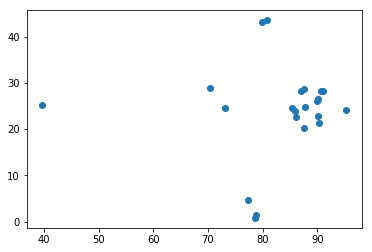

In [54]:
def visualize_players(game_id, play_id, action, matrix):
    punt_game = matrix.loc[matrix.GameKey==game_id]
    punt_play = punt_game.loc[punt_game.PlayID==play_id]
    action = punt_play.loc[punt_play.Event==action]
    
    plt.scatter(action.x,action.y)

visualize_players(192,2801,'punt',reg_2016_2)

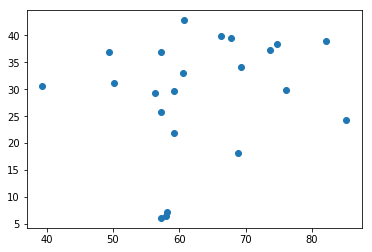

In [55]:
visualize_players(192,2801,'punt_received',reg_2016_2)

Play 2 is a 8-2-1 formation. The first visual shows the players on the field when the punt happens. The second visual shows the players on the field when the punt is received.


It is interesting to note the increased spacing on the field in visual 2. This play ended up as a 27 yard gain. This is because he was able to make the initial defenders miss and find open space afterward for the big gain.

This is a common trend amongst returns in the 8-2-1 formation.

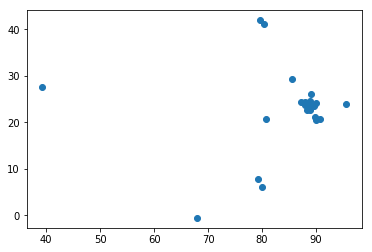

In [71]:
visualize_players(582,3079,'punt',reg_2017_3)

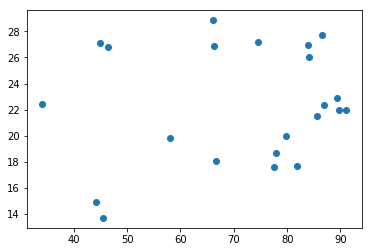

In [72]:
visualize_players(582,3079,'punt_received',reg_2017_3)

The following analyses were potential rules that I looked into but did not have sufficient enough evidence to include in my final recommendations

#1 - Investigating whether 'gunners' are at more risk than other positions. If so, there could be potential to remove that position or modify it in some way.

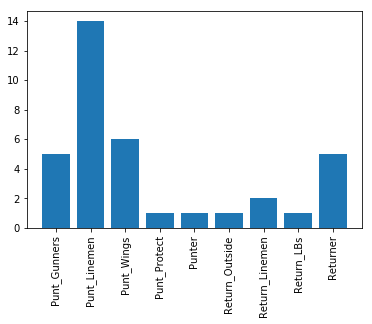

In [59]:
injured_players = pd.merge(injuries, play_player_role, on=['GSISID','PlayID','GameKey'])

def get_positions(lst):
    PRW = 0
    PDL2 = 0
    PRG = 0
    PLS = 0 
    PLW = 0
    P = 0
    PLM = 0
    PLG = 0
    GL = 0
    VL = 0
    PFB = 0
    PRT = 0
    PLT = 0
    GR = 0
    PPL = 0
    VRi = 0
    PDR2 = 0
    PDR1 = 0
    VRo = 0
    PR = 0
    PDL1 = 0
    PDR3 = 0
    PLR = 0
    PDR4 = 0
    PPR = 0
    VR = 0
    VLi = 0
    PDR5 = 0
    PLL1 = 0
    PDL3 = 0
    PLL2 = 0
    PLR2 = 0
    PLL = 0
    VLo = 0
    PLR1 = 0
    PDL4 = 0

    for j in lst:
        if j == 'PRW':
            PRW += 1
        elif j == 'PDL2':
            PDL2 += 1
        elif j == 'PRG':
            PRG += 1
        elif j == 'PLS':
            PLS += 1
        elif j == 'PLW':
            PLW += 1
        elif j == 'P':
            P += 1
        elif j == 'PLM':
            PLM += 1
        elif j == 'PLG':
            PLG += 1
        elif j == 'GL':
            GL += 1
        elif j == 'VL':
            VL += 1
        elif j == 'PFB':
            PFB += 1
        elif j == 'PRT':
            PRT += 1
        elif j == 'PLT':
            PLT += 1
        elif j == 'GR':
            GR += 1
        elif j == 'PPL':
            PPL += 1
        elif j == 'VRi':
            VRi += 1
        elif j == 'PDR2':
            PDR2 += 1
        elif j == 'PDR1':
            PDR1 += 1
        elif j == 'VRo':
            VRo += 1
        elif j == 'PR':
            PR += 1
        elif j == 'PDL1':
            PDL1 += 1
        elif j == 'PLR':
            PLR += 1
        elif j == 'PDR4':
            PDR4 += 1
        elif j == 'PPR':
            PPR += 1
        elif j == 'VR':
            VR += 1
        elif j == 'VLi':
            VLi += 1
        elif j == 'PDR5':
            PDR5 += 1
        elif j == 'PLL1':
            PLL1 += 1
        elif j == 'PDL3':
            PDL3 += 1
        elif j == 'PLL3':
            PLL2 += 1
        elif j == 'PLR2':
            PLR2 += 1
        elif j == 'PLL':
            PLL += 1
        elif j == 'VLo':
            VLo += 1
        elif j == 'PLR1':
            PLR1 += 1
        elif j == 'PDL4':
            PDL4 += 1        

    p_gunners = (GL + GR)
    p_linemen = (PLT+PLG+PLS+PRG+PRT)
    p_wings = (PLW+PRW)
    p_protect = (PPR+PPL)
    p_punter = (P)
    r_outside = (VRo+VRi+VR+VLo+VLi+VL)
    r_linemen = (PDR3+PDR2+PDR1+PDR4+PDR5+PDL3+PDL2+PDL1+PDL4)
    r_lbs = (PLR+PLR1+PLR2+PLL+PLL1+PLL2+PLM)
    r_ret = PR
    
    tot = [p_gunners,p_linemen,p_wings,p_protect,p_punter,r_outside,r_linemen,r_lbs,r_ret]
    positions = ['Punt_Gunners', 'Punt_Linemen','Punt_Wings','Punt_Protect','Punter','Return_Outside','Return_Linemen','Return_LBs','Returner']
    
    plt.bar(positions,tot)
    plt.xticks(rotation=90)
get_positions(injured_players.iloc[:,-1])

Only 5 gunners have been concussed, which does not appear to be big enough to make an impact. The reducting in returns coming from the 8-2-1 rule will help reduce concussions of gunners, without a significant change to that position.

#2 - Checking the impact of the ball originating on the hash marks versus the middle of the field. The hypothesis here was that if the punt is on the hash mark, a punter is more likely to punt out of bounds (a safer play) versus punt to the middle of the field. In the correlation matrix above where the ball is on the field along the y-axis doesn't have any relationship with if the punt goes out of bounds or not. 

#3 - Implementing the same touchback rule that was implemented on the kickoff (25 yard line)

In [62]:
import numpy as np

distfromendzone = []
puntdist = []
retdist = []
descr = []

for row in range(len(play_info)):
    poss = play_info.iloc[row,10]
    ydline = int((play_info.iloc[row,7])[-2:])
    play = (str(play_info.iloc[row,-1]))
    
    if poss in play_info.iloc[row,7]:
        distfromendzone.append(100 - ydline)
    else:
        distfromendzone.append(ydline)

    if " punts " in play:
        result = play.split(" punts ",1)[1]
        yards = result[0:2]
        if yards != 'no':
            puntdist.append(int(yards))
    else:
        puntdist.append('NA')
    
    if " for " in play:
        result = play.split(" for ",1)[1]
        yards = result[0:2]
        if yards == 'no':
            yards_ = 0
        if yards == 'on':
            yards = yards_  
        if yards == 'L.':
            yards = yards_  
        if yards != 'no':
            yards_ = int(yards)
    else:
        yards_ = 0
    
    retdist.append(yards_)
    descr.append(play)

D = {'Yard Line': distfromendzone, 'Punt Distance': puntdist, 'Return Distance': retdist, 'Description': descr}
df = pd.DataFrame(data=D)
notna = df['Punt Distance']!='NA'

df2 = df[notna]

df2['Landed'] = np.array(df2['Yard Line']) - np.array(df2['Punt Distance'])

close = df2['Yard Line']>0
df3 = df2[close]

close_2 = df2['Yard Line']<50
df4 = df3[close_2]

fc = 0
ob = 0
tb = 0
rt = 0
mf = 0
dn = 0

for i in range(len(df4)):
    
    if "fair catch" in df4.iloc[i,3]:
        fc += 1
    if "out of bounds" in df4.iloc[i,3]:
        ob += 1
    if "Touchback" in df4.iloc[i,3]:
        tb += 1
    if " for " in df4.iloc[i,3]:
        rt += 1
    if "MUFFS" in df4.iloc[i,3]:
        mf += 1
    if "downed" in df4.iloc[i,3]:
        dn += 1

outcomes = ['Fair Catch', 'OB', 'Touchback', 'Return', 'Muff', 'Downed']
total_plays = [fc,ob,tb,rt,mf,dn]

dc = {'Outcomes': outcomes, 'Total Plays': total_plays}
df50 = (pd.DataFrame(dc))

print(str(round(rt/len(df4),4)*100)+"% of punts in coffin corner situations (punts on the plus side of the field) were returned")

5.5% of punts in coffin corner situations (punts on the plus side of the field) were returned


C:\Users\Yofftop\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The general rule of thumb is that returners are told not to field a punt inside the 10 because there is a good chance it will bounce into the end zone for a touch back. Only 5% of the time do they actually do this. Changing the touchback and further incentivizing not fielding the punt would have minimal affect on the big picture. 